# desarrollo

## LIBRERIAS, VARIABLES Y CONSTAN

In [92]:
import os
import sqlite3

import xlwings as xw
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#desactivar advertencias de pandas
import warnings
pd.options.mode.chained_assignment = None  # default='warn'


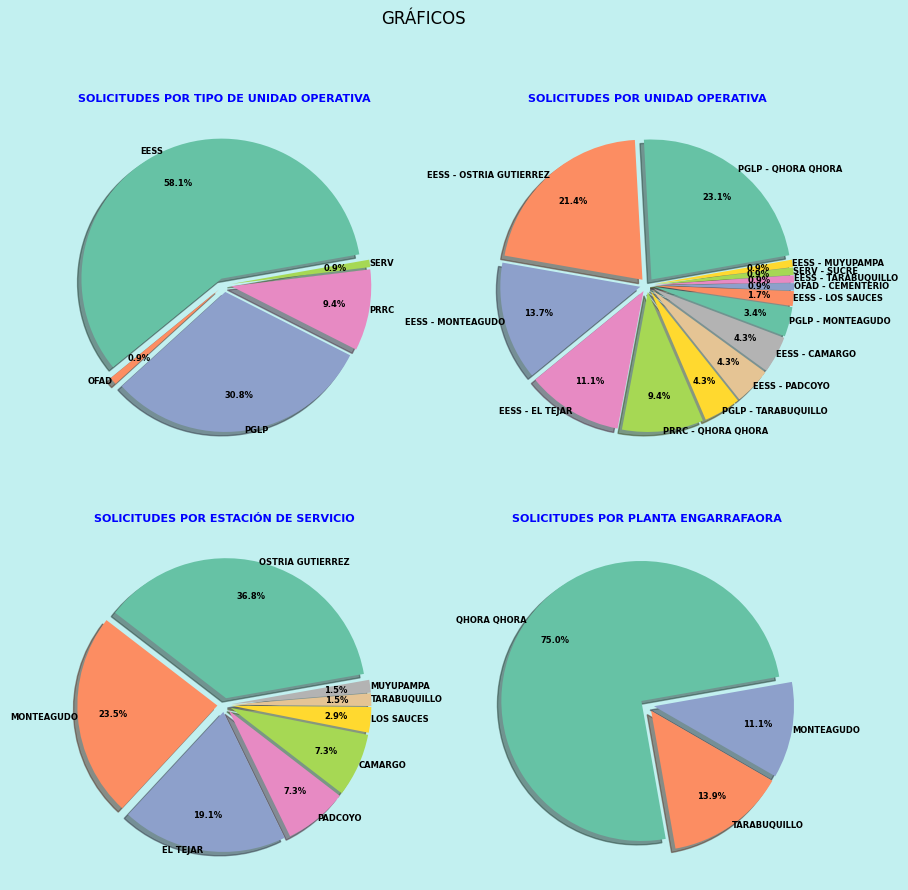

In [100]:
#def Mtto02():
    #db_file = os.path.join(os.path.dirname(wb.fullname), "GCOM_MTTO_NB12017.db")
    #conexion = sqlite3.connect(db_file, detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES)
conexion = sqlite3.connect("GCOM_MTTO_NB12017.db")
    
query = "SELECT * FROM maco"
df = pd.read_sql_query(query, conexion)
   
dtf = df[['maco_nb', 'tisu_nb', 'sucu_nb', 'area_nb', 'maco_ano_int', 'maco_mes_int', 'maco_maquinaria_vc']]
dtf[['tisu_nb2', 'sucu_nb2', 'area_nb2']] = dtf[['tisu_nb', 'sucu_nb', 'area_nb']]
dtf_filtrado = dtf
dtf_filtrado['tisu'] = dtf['tisu_nb']
    
dtf_tisu = pd.read_sql_query("SELECT * FROM tisu;", conexion)
dtf_sucu = pd.read_sql_query("SELECT * FROM sucu2;", conexion)
dtf_area = pd.read_sql_query("SELECT * FROM area;", conexion) 
        
mapeo_tisu = dtf_tisu.set_index('tisu_nb')['tisu_nombre_vc'].to_dict()
mapeo_tisu_sigla = dtf_tisu.set_index('tisu_nb')['tisu_sigla_vc'].to_dict()

mapeo_sucu = dtf_sucu.set_index('sucu_nb')['sucu_nombre_vc'].to_dict()
mapeo_area = dtf_area.set_index('area_nb')['area_nombre_vc'].to_dict()

dtf_filtrado['tisu_nb2'] = dtf['tisu_nb2'].map(mapeo_tisu)
dtf_filtrado['sucu_nb2'] = dtf['sucu_nb2'].map(mapeo_sucu)
dtf_filtrado['area_nb2'] = dtf['area_nb2'].map(mapeo_area)
dtf_filtrado['tisu'] = dtf['tisu'].map(mapeo_tisu_sigla)
        
total_registros = len(dtf_filtrado)
conteo_tisu_nb = dtf_filtrado['tisu_nb'].value_counts()
conteo_sucu_nb = dtf_filtrado['sucu_nb'].value_counts()
conteo_area_nb = dtf_filtrado['area_nb'].value_counts()

dtf_filtrado['tisu-sucu'] = dtf_filtrado['tisu'].astype(str) + ' - ' + dtf_filtrado['sucu_nb2'].astype(str)
dtf_filtrado.set_index('maco_nb', inplace=True)
conexion.close()

#TABLAS
# TABLA TISU #######################################################
dtf_tisu = dtf_filtrado[['tisu_nb2', 'tisu', 'maco_ano_int', 'maco_mes_int']]
dtf_tisu_por = dtf_tisu.groupby('tisu').size().reset_index(name='counts')
dtf_tisu_por['por_tisu'] = (dtf_tisu_por['counts'] / total_registros * 100).round(2)

# TODAS LAS UNIDADES SUCUS #####################################################
dtf_sucus = dtf_filtrado['tisu-sucu'].value_counts().reset_index()
dtf_sucus['por_sucus'] = (dtf_sucus['count'] / total_registros * 100).round(2)

# PREPARAR TABLA SUCU EESS ########################################################
dtf_sucu_eess = dtf_filtrado[dtf_filtrado['tisu_nb2'] == "ESTACION DE SERVICIO"]['sucu_nb2'].value_counts().reset_index()
dtf_sucu_eess['por_sucu_eess'] = (dtf_sucu_eess['count'] / total_registros * 100).round(2)

# PREPARAR TABLA SUCU PE#############################################################
dtf_sucu_pe = dtf_filtrado[dtf_filtrado['tisu_nb2'] == "PLANTA ENGARRAFADORA"]['sucu_nb2'].value_counts().reset_index()
dtf_sucu_pe['por_sucu_pe'] = (dtf_sucu_pe['count'] / total_registros * 100).round(2)

#PREPARAR GRÁFICO
sns.set_palette("Set2")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
#fig.patch.set_facecolor('xkcd:light grey')
fig.patch.set_facecolor('#c2f0f0')
##c2f0f0
fig.suptitle('SOLICITUDES DE MANTENIMIENTO CORRECTIVO', fontsize=14, fontweight='bold', color='blue')

#GRÁFICAR TISU
ax1.pie(
    dtf_tisu_por['por_tisu'],
    labels=dtf_tisu_por['tisu'],
    autopct='%1.1f%%',
    startangle=10,
    shadow=True,
    explode=([0.05] * len(dtf_tisu_por)),
    textprops={'fontsize': 6, 'fontweight': 'bold', 'va': 'center'},
    labeldistance=1,
    pctdistance=0.75
    )
ax1.set_title('SOLICITUDES POR TIPO DE UNIDAD OPERATIVA', fontsize=10, fontweight='bold', color='blue')

#GRÁFICAR SUCUS
ax2.pie(
    dtf_sucus['por_sucus'],
    labels=dtf_sucus['tisu-sucu'],
    autopct='%1.1f%%',
    startangle=10,
    shadow=True,
    explode=([0.05] * len(dtf_sucus)),
    textprops={'fontsize': 6, 'fontweight': 'bold', 'va': 'center'},
    labeldistance=1,
    pctdistance=0.75
    )
ax2.set_title('SOLICITUDES POR UNIDAD OPERATIVA', fontsize=10, fontweight='bold', color='blue')

#GRÁFICAR SUCU EESS
ax3.pie(
    dtf_sucu_eess['por_sucu_eess'], 
    labels=dtf_sucu_eess['sucu_nb2'], 
    autopct='%1.1f%%', 
    startangle=10, 
    shadow=True, 
    explode=([0.05] * len(dtf_sucu_eess)),
    textprops={'fontsize': 6, 'fontweight': 'bold', 'va': 'center'}, 
    labeldistance=1, 
    pctdistance=0.75
    )
ax3.set_title('SOLICITUDES POR ESTACIÓN DE SERVICIO', fontsize=10, fontweight='bold', color='blue')

#GRÁFICAR SUCU PE
ax4.pie(
    dtf_sucu_pe['por_sucu_pe'], 
    labels=dtf_sucu_pe['sucu_nb2'], 
    autopct='%1.1f%%', 
    startangle=10, 
    shadow=True, 
    explode=([0.05] * len(dtf_sucu_pe)),
    textprops={'fontsize': 6, 'fontweight': 'bold', 'va': 'center'}, 
    labeldistance=1, 
    pctdistance=0.75
    )
ax4.set_title('SOLICITUDES POR PLANTA ENGARRAFAORA', fontsize=10, fontweight='bold', color='blue')

fig.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

### pasar datos a excel

In [94]:
    wb = xw.Book.caller()
    sht = wb.sheets.active
    if not dtf_filtrado.empty:
        sht.range("A9").expand().clear_contents()
        sht.range("A9").value = dtf_filtrado.columns.tolist()  # Encabezados
        sht.range("A10").value = dtf_filtrado.values.tolist()  # Datos
    else:
        sht.range("A10").value = "Empty Playlist!"
    
    
    
    #formatos
    enc_range = sht.range("A9").expand('right')
    
    for cell in enc_range:
        cell.api.Font.Name = 'Comic Sans MS'
        cell.api.Font.Size = 12
        cell.api.Font.Bold = True
        #cell.column_width = 25
        cell.color = (255,0,255) 
        cell.api.Font.Color = 0xFFFFFF
        
    enc_range.api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter
    enc_range.autofit()
    
    cuerpo_range = enc_range = sht.range("A9").expand()
    cuerpo_range.api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter
    cuerpo_range.autofit()

Exception: Book.caller() must not be called directly. Call through Excel or set a mock caller first with Book.set_mock_caller().